# Linear example

Here we adapt the example discussed by Wu, Brunton, Rezven (Wu et al., R. Soc. Interface, 2018). They proposed a linear 3D system with non-normal eigenspaces observed via nonlinear observables to benchmark DMD's ability to recover the spectrum. They found that even weak non-normality and nonlinearity caused difficulties for DMD when applied to possibly noisy data. Here we repeat this analysis without noise to compare the results from DMD, EDMD and DDL models. 


To set up the system, define a block-diagonal matrix $\Lambda$ and a basis transformation matrix $R$ of the form

$$
\Lambda=\left(\begin{array}{ccc}
a & -b & 0\\
b & a & 0\\
0 & 0 & c
\end{array}\right),\quad a,b,c\in\mathbb{R},\qquad R=\left(\begin{array}{ccc}
1 & 0 & \sin\theta_{1}\cos\theta_{2}\\
0 & 1 & \sin\theta_{1}\sin\theta_{2}\\
0 & 0 & \cos\theta_{2}
\end{array}\right),
$$
to define the linear discrete dynamical system 

$$
x(n+1)=\left(R\Lambda R^{-1}\right)x(n).
$$

Thi system is then observed via a nonlinear observable $y(x)$ defined as 

$$
y(x)=\left(\begin{array}{c}
x_{1}+0.1\left(x_{1}^{2}+x_{2}x_{3}\right)\\
x_{2}+0.1\left(x_{2}^{2}+x_{1}x_{3}\right)\\
x_{3}+0.1\left(x_{3}^{2}+x_{1}x_{2}\right)
\end{array}\right).
$$

In the following, we set 

$$
a=0.45\sqrt{3}, b=0.5, c=0.6, \theta_{1}=1.56, \text{ and } \theta_{2}=0.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
alpha = 0.9 * np.sqrt(3)/2
beta = 0.5
lam = 0.6
Lambda = np.array([[alpha, beta, 0 ], [-beta, alpha, 0], [0,0,lam]])

In [3]:
Lambda

array([[ 0.77942286,  0.5       ,  0.        ],
       [-0.5       ,  0.77942286,  0.        ],
       [ 0.        ,  0.        ,  0.6       ]])

In [4]:
s = 1
thet = 1.5
ph = 0
Q = np.array([[1, 0, np.sin(thet) * np.cos(ph)],
              [0, 1, np.sin(thet) * np.sin(ph)],
              [0, 0, np.cos(thet)]])
S = np.array([[s, 0, 0], 
              [0, 1, 0],
             [0, 0, 1]])


In [5]:
Q

array([[1.        , 0.        , 0.99749499],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.0707372 ]])

Create the transformed linear system

In [6]:
A = np.linalg.multi_dot([Q, S, Lambda, np.linalg.inv(S), np.linalg.inv(Q)])

In [7]:
A

array([[ 0.77942286,  0.5       , -2.53011715],
       [-0.5       ,  0.77942286,  7.05070997],
       [ 0.        ,  0.        ,  0.6       ]])

In [8]:
def nonlin_obs(x):
    obs = np.array([x[0,:] + 0.1 * (x[0,:]**2+ x[1,:]*x[2,:]),
                     x[1,:] + 0.1 * (x[1,:]**2 + x[0,:]*x[2,:]),
                     x[2,:] + 0.1 * (x[2,:]**2 + x[0,:]*x[1,:])])
    return obs

In [9]:
np.random.seed(3)
ics = (np.random.rand(4,3)-0.5) * 1

In [10]:
np.linalg.norm(ics,axis=1)

array([0.29937731, 0.55818703, 0.65350957, 0.47579746])

In [11]:
def iterate(x0, A, n):
    iterates = [x0]
    for i in range(n):
        iterates.append(A@iterates[-1])
    return np.array(iterates).T

In [21]:
np.random.seed(4)


In [22]:
trajectories_linear = [iterate(ics[i], A, 100) for i in range(len(ics))]
trajectories_nonlinear = [nonlin_obs(trajectories_linear[i]) for i in range(len(ics))]

In [85]:
train_nonlinear = [ t + (np.random.rand(*t.shape) - 0.5)*5e-2 for t in trajectories_nonlinear[:3]]
test_nonlinear = trajectories_nonlinear[-1]


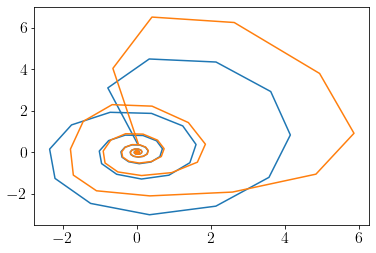

In [86]:
plt.plot(trajectories_linear[1][0,:], trajectories_linear[1][1,:])
plt.plot(trajectories_nonlinear[1][0,:], trajectories_nonlinear[1][1,:])

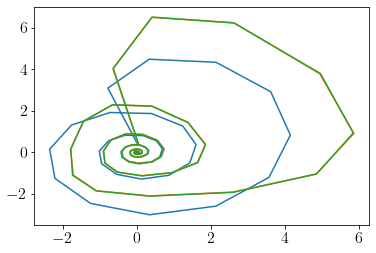

In [87]:
plt.plot(trajectories_linear[1][0,:], trajectories_linear[1][1,:])
plt.plot(trajectories_nonlinear[1][0,:], trajectories_nonlinear[1][1,:])
#plt.plot(trajectories_linear[1][0,:], trajectories_linear[1][1,:])
plt.plot(train_nonlinear[1][0,:], train_nonlinear[1][1,:])

In [88]:
%load_ext autoreload
%autoreload 2
%aimport datadrivenlinearization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
dmd.coef_

array([[ 0.76576634,  0.43177282,  0.22923451],
       [-0.45236505,  0.90725388, -0.02473499],
       [-0.01951739,  0.02724741,  0.55249799]])

In [185]:
dmd = datadrivenlinearization.DMD(train_nonlinear)
order = 4
edmd = datadrivenlinearization.EDMD(train_nonlinear,degree = order)

d = datadrivenlinearization.DataDrivenLinearization(3, degree = order)
d.fit_lsq_inv(train_nonlinear,
              initial_matrix = dmd.coef_, initial_transformation='zero', method = 'trf',
              alpha = 0)


Initial cost:  48.100268814796415
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.905e-01 -1.711e-02 ... -1.859e-03 -9.831e-04]
           x: [ 7.633e-01  5.187e-01 ... -7.012e+00  8.881e+00]
        cost: 0.5114798339812202
         jac: [[ 1.559e-01  2.098e-01 ... -0.000e+00  0.000e+00]
               [ 4.802e-01 -7.719e-01 ... -0.000e+00  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00 ... -1.921e-07  3.342e-07]
               [ 0.000e+00  0.000e+00 ... -4.217e-08  9.569e-08]]
        grad: [-1.157e-07  1.017e-07 ...  1.316e-08  8.558e-09]
  optimality: 0.0030741250245283334
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 218
        njev: 179
Final cost:  1.0229596679624404


1.0229596679624404

In [186]:
predicted = d.predict(test_nonlinear[:,0].reshape(-1,1), 100)


In [187]:
invtrf = d.inverse_transform(predicted)

In [188]:
from sklearn.preprocessing import PolynomialFeatures
nonlinear_features = PolynomialFeatures(degree = order, include_bias=False).fit_transform(test_nonlinear.T).T

Edmd_prediction = iterate(nonlinear_features[:,0], edmd.coef_, 100)
dmd_prediction = iterate(test_nonlinear[:,0], dmd.coef_, 100)


In [189]:
import distinctipy 
colors2 = distinctipy.get_colors(10, n_attempts = 7000, rng = 1, colorblind_type='Tritanopia')
#distinctipy.color_swatch(colors2)

In [190]:
colors = distinctipy.get_colors(3, colorblind_type='Deuteranomaly',exclude_colors = [(1,1,1), (0,0,0)], rng = 6)
#distinctipy.color_swatch(colors)
#

In [191]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16,"font.family": "serif",})

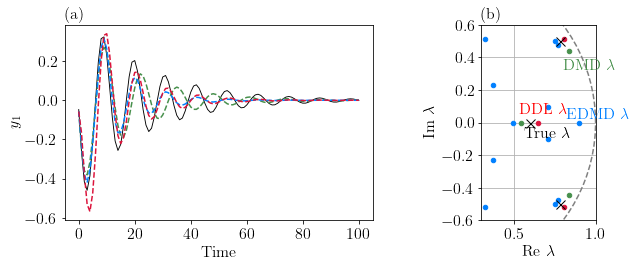

In [192]:
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(invtrf[0,:],'-', c='black', linewidth = 0.9,  label = 'True trajectory')
ax.plot(dmd_prediction[0,:],'--', linewidth = 1.5, c= colors2[8], label = 'DMD prediction')
ax.plot(Edmd_prediction[0,:],'--', linewidth = 1.5, c = colors[0], label = 'EDMD predition')
ax.plot(test_nonlinear[0,:],'--', linewidth = 1.5, c = 'crimson', label = 'DDL prediction')

ax.set_xlabel('Time')
ax.set_ylabel('$y_1$')
#plt.plot(trajectories_nonlinear[0][0,:])
#ax.legend()
real_eigs, _ = np.linalg.eig(A)
dmd_eigs, _ = np.linalg.eig(dmd.coef_)
edmd_eigs, _ = np.linalg.eig(edmd.coef_)
ddl_eigs, _ = np.linalg.eig(d.linear_model)
phii_ = np.linspace(0, 2*np.pi, 100)

ax2.plot(np.real(dmd_eigs),np.imag(dmd_eigs),'.', markersize = 9, c= colors2[8])
ax2.plot(np.real(edmd_eigs),np.imag(edmd_eigs),'.',  markersize = 9,c=colors[0])
ax2.plot(np.real(ddl_eigs),np.imag(ddl_eigs),'.',  markersize = 9,c='crimson')
ax2.plot(np.real(real_eigs),np.imag(real_eigs),'x', markersize = 9, c='black')
ax2.plot(np.sin(phii_), np.cos(phii_), '--', c='grey')
ax2.grid()
ax2.axis('scaled')
ax2.set_xlim(0.3, 1.)
ax2.set_ylim(-0.6, 0.6)
ax2.text(0.56, -0.1, 'True $\lambda$', color = 'black')
ax2.text(0.8, 0.32, 'DMD $\lambda$', color = colors2[8])
ax2.text(0.82, 0.02, 'EDMD $\lambda$', color = colors[0])
ax2.text(0.53, 0.05, 'DDL $\lambda$', color = 'red')
ax2.set_xlabel('Re $\lambda$')
ax2.set_ylabel('Im $\lambda$')
labels = ['(a)', '(b)']
for a,l in zip([ax, ax2], labels):
    a.text(0, 1.03, l, transform=a.transAxes)
    
fig.tight_layout()
plt.savefig('Noise_4rd_ord.pdf', bbox_inches='tight' )

## fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(invtrf[0,:],'-', c='black', linewidth = 0.9,  label = 'True trajectory')
ax.plot(dmd_prediction[0,:],'--', linewidth = 1.5, c= colors2[8], label = 'DMD prediction')
ax.plot(Edmd_prediction[0,:],'--', linewidth = 1.5, c = colors[0], label = 'EDMD predition')
ax.plot(test_nonlinear[0,:],'--', linewidth = 1.5, c = 'crimson', label = 'DDL prediction')

ax.set_xlabel('Time')
ax.set_ylabel('$y_1$')
#plt.plot(trajectories_nonlinear[0][0,:])
#ax.legend()
real_eigs, _ = np.linalg.eig(A)
dmd_eigs, _ = np.linalg.eig(dmd.coef_)
edmd_eigs, _ = np.linalg.eig(edmd.coef_)
ddl_eigs, _ = np.linalg.eig(d.linear_model)
phii_ = np.linspace(0, 2*np.pi, 100)

ax2.plot(np.real(dmd_eigs),np.imag(dmd_eigs),'.', markersize = 9, c= colors2[8])
ax2.plot(np.real(edmd_eigs),np.imag(edmd_eigs),'.',  markersize = 9,c=colors[0])
ax2.plot(np.real(ddl_eigs),np.imag(ddl_eigs),'.',  markersize = 9,c='crimson')
ax2.plot(np.real(real_eigs),np.imag(real_eigs),'x', markersize = 9, c='black')
ax2.plot(np.sin(phii_), np.cos(phii_), '--', c='grey')
ax2.grid()
ax2.axis('scaled')

ax2.set_xlim(0.5, 1.)
ax2.set_ylim(-0.6, 0.6)
ax2.text(0.56, -0.1, 'True $\lambda$', color = 'black')
ax2.text(0.8, 0.32, 'DMD $\lambda$', color = colors2[8])
ax2.text(0.82, 0.02, 'EDMD $\lambda$', color = colors[0])
ax2.text(0.53, 0.05, 'DDL $\lambda$', color = 'red')
ax2.set_xlabel('Re $\lambda$')
ax2.set_ylabel('Im $\lambda$')
labels = ['(a)', '(b)']
for a,l in zip([ax, ax2], labels):
    a.text(0, 1.03, l, transform=a.transAxes)
    
fig.tight_layout()
